# CSCI 6920 - Homework 3

## Problem Statement 
When looking at the night sky, we call all the bright dots stars. However, this is not only completely correct. Many of the bright dots are also galaxies and quasars. These different celestial objects emit different photonic information, which we can capture using telescopes. However, differentiating between the objects is a non-trivial task. My goal in this homework is to use a dataset containing observation features and to classify an observation as a star, galaxy, or quasar.

The dataset I used is the [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) from Kaggel

## Setup

In [637]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
from torch import nn
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import confusion_matrix, roc_auc_score

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Task 1

All of my references are from the pytorch documentation.
* [torch.nn.sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) - I used this source to consturct a squencial model so I could define any depth neural network.
* [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) - I used this source to find how the loss function will take output from the model.
* [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) - I used this source to learn about the Adam optimizer hyperparameters and how to consruct the object.
* [Datasets and Dataloaders](https://pytorch.org/docs/stable/data.html) - I used this source to learn how to create a dataset object from torch tensors and the parameters of the dataloader class.

## Task 2
### Exploratory Data Analysis

In [638]:
seed = 10
data_path = "..\\data\\star_classification.csv"
star_df = pd.read_csv(data_path) # load data.

Review varaibles:

In [639]:
# display all avaiable features.
star_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [640]:
# sample of datapoints.
star_df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [641]:
# Statistical information regarding each feature.
star_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


1. We note that the varable class is of type string which means we need to encode the labels.
2. Reviewing the describtion tablet it seems that rerun_ID gives no new information as its means standard devision is 0 so we drop this feature. 
3. Also -9999 appears several times in the minumum which seems like a supplement for NaN as its very far from the mean. We drop rows that contain this value.

In [642]:
# 1. encode labels
le = LabelEncoder()
le.fit(star_df["class"].unique())
star_df["class"] = le.transform(star_df["class"])

In [643]:
# 2. drop rerun_ID
star_df = star_df.drop(["rerun_ID"], axis = 1)

In [644]:
# 3. remove rows that contain -9999 as an element.
for c in star_df.columns:
    star_df = star_df[star_df[c] != -9999]

In [645]:
star_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,4481.403354,3.511625,186.127011,5.783903e+18,0.621476,0.576667,5137.027890,55588.653687,449.315613
std,8.438450e+12,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1964.739021,1.586913,149.007687,3.324026e+18,0.816771,0.730709,2952.312485,1808.492217,272.498252
min,1.237646e+18,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,109.000000,1.000000,11.000000,2.995191e+17,0.000000,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,3187.000000,2.000000,82.000000,2.844137e+18,0.000000,0.054522,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4188.000000,4.000000,146.000000,5.614896e+18,0.000000,0.424176,4987.000000,55869.000000,433.000000
75%,1.237668e+18,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5326.000000,5.000000,241.000000,8.332365e+18,1.000000,0.704172,7400.500000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,6.000000,989.000000,1.412694e+19,2.000000,7.011245,12547.000000,58932.000000,1000.000000


Check for missing values:

In [646]:
star_df.isna().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

No missing values in this dataset

Remove insignificant features to the target class:

In [647]:
feature_corr = star_df.corr().abs()["class"] # corrolation of of features based on the target.
star_df = star_df.loc[:, feature_corr >= 0.05] # take the most correlated features.

Evaluate remaining variables:

In [648]:
star_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u         99999 non-null  float64
 1   g         99999 non-null  float64
 2   r         99999 non-null  float64
 3   z         99999 non-null  float64
 4   class     99999 non-null  int32  
 5   redshift  99999 non-null  float64
dtypes: float64(5), int32(1)
memory usage: 5.0 MB


In [649]:
# Statistical information regarding each feature split on the target class.
star_df.groupby("class").describe()

u                                                               \
         count       mean       std       min       25%       50%       75%   
class                                                                         
0      59445.0  22.587379  2.264355  13.89799  20.79476  22.84177  24.20741   
1      18961.0  21.547619  1.495879  10.99623  20.63764  21.50324  22.28647   
2      21593.0  21.153830  2.360482  12.10168  19.32774  21.01065  22.96063   

                       g                                                     \
            max    count       mean       std       min       25%       50%   
class                                                                         
0      29.32565  59445.0  20.906101  2.107755  12.67902  18.91268  21.58220   
1      32.78139  18961.0  20.926193  1.163239  13.66217  20.24973  21.05629   
2      30.66039  21593.0  19.617142  2.119478  10.49820  18.03487  19.54283   

                                 r                                           \
            75%       max    count       mean       std       min       25%   
class                                                                         
0      22.44513  31.60224  59445.0  19.587552  1.874133  11.74664  17.81715   
1      21.68777  27.89482  18961.0  20.624089  1.084237  12.35763  20.00633   
2      21.22877  30.60700  21593.0  18.947005  1.972825   9.82207  17.45395   

                                           z                                  \
            50%       75%       max    count       mean       std        min   
class                                                                          
0      20.10459  20.97461  29.57186  59445.0  18.449156  1.656302  10.897380   
1      20.77272  21.41345  27.39709  18961.0  20.266732  1.095076  11.302470   
2      18.95513  20.55757  29.37411  21593.0  18.334295  1.843201   9.612333   

                                              redshift                      \
            25%       50%       75%       max    count      mean       std   
class                                                                        
0      17.09567  18.76663  19.47226  29.38374  59445.0  0.421596  0.264858   
1      19.64425  20.37397  21.00123  28.79055  18961.0  1.719676  0.913954   
2      16.96417  18.31923  19.72963  26.42779  21593.0 -0.000115  0.000465   

                                                         
            min       25%       50%       75%       max  
class                                                    
0     -0.009971  0.164527  0.456274  0.594699  1.995524  
1      0.000461  1.106605  1.617232  2.220279  7.011245  
2     -0.004136 -0.000295 -0.000076  0.000075  0.004153

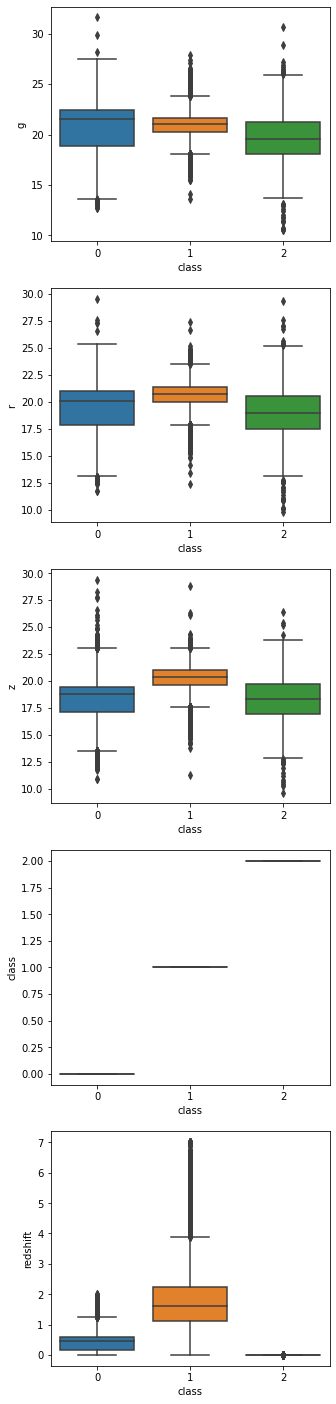

In [650]:
N = len(star_df.columns[1:])

fig, axs = plt.subplots(N, figsize=(5, N*5))
for ax, column in zip(axs, star_df.columns[1:]):
    sns.boxplot(data=star_df, x="class", y=column, ax=ax)

plt.show()

We note the remaining features distributions seem differ depending on the class which should help the model classify.

<AxesSubplot:>

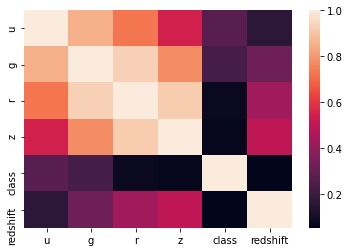

In [651]:
sns.heatmap(data=star_df.corr().abs())

u, g, r and z seem to have high corolation between one another. This suggests that a non-linear clasifier may do better on this task.

Class distribution:

In [652]:
# check class balance in dataset.
print("Percentage of each Class:")
print(star_df["class"].value_counts(normalize=True))
print("\nNumber of Samples of each Class:")
print(star_df["class"].value_counts())

mapping = {le.inverse_transform([t])[0]: t for t in range(len(star_df["class"].unique())) }
print("Where:", mapping)

Percentage of each Class:
0    0.594456
2    0.215932
1    0.189612
Name: class, dtype: float64

Number of Samples of each Class:
0    59445
2    21593
1    18961
Name: class, dtype: int64
Where: {'GALAXY': 0, 'QSO': 1, 'STAR': 2}


### Splitting Datatset to Train/Validation/Test Sets

In [653]:
y = star_df["class"].to_numpy()
X = star_df.drop("class", axis=1).to_numpy()

In [654]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [655]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.7, stratify=y_test)

In [656]:
scaler = StandardScaler().fit(X_train) # mean center and scale by sd the data.

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [657]:
print(f"Dataset Dimensions:\n\tX_train: {X_train.shape}; y_train: {y_train.shape}\n\tX_valid: {X_valid.shape}; y_valid: {y_valid.shape}\n\tX_test: {X_test.shape}; y_test: {y_test.shape}")

Dataset Dimensions:
	X_train: (79999, 5); y_train: (79999,)
	X_valid: (6000, 5); y_valid: (6000,)
	X_test: (14000, 5); y_test: (14000,)


### Create Neural Network and Helper Functions

In [659]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_list):
        super(NeuralNetwork, self).__init__()
        
        self.model = nn.Sequential()
        
        for in_size, out_size in zip(layer_list[:-1], layer_list[1:]):
            self.model.append(nn.Linear(in_size, out_size))
            self.model.append(nn.ReLU())
        
                
    def forward(self, X):
        return self.model(X)

def fit(model, criterion, optimizer, epochs, data, progress=True):
    train_generator, valid_generator = data
    
    history = {
                "train_loss": [],
                "validation_loss": [],
                "train_accuracy": [],
                "validation_accuracy": []
    }
    
    for e in range(epochs):
        model.train()
        
        if progress:
            print("Epoch:", e+1)
            train_loader = tqdm(train_generator)
            train_loader.set_description(desc=f"Training loss: {np.NAN}")
        else:
            train_loader = train_generator
            
        loss = 0
        for i, (X, y) in enumerate(train_loader):

            y_hat = model(X)
            batch_loss = criterion(y_hat, y)
            loss += batch_loss.item()
        
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            if progress:
                train_loader.set_description(desc=f"Training loss: {loss/(i+1)}")
        
        train_eval = evaluate(model, criterion, train_generator)
        valid_eval = evaluate(model, criterion, valid_generator)
        
        history["train_loss"].append(train_eval[0])
        history["validation_loss"].append(valid_eval[0])
        history["train_accuracy"].append(train_eval[1])
        history["validation_accuracy"].append(valid_eval[1])
        
        if progress:
            print(f"Train loss: {train_eval[0]} | Train Accuracy: {train_eval[1]} || Validation loss: {valid_eval[0]} | Validation Accuracy: {valid_eval[1]}")
            
    return history

def evaluate(model, criterion, data_loader):
    model.eval()
    
    loss = 0
    acc = 0
    
    for X, y in data_loader:
        y_hat = model(X)
        loss += float(criterion(y_hat, y))
        
        y_hat = torch.argmax(y_hat, axis=1)
        
        acc += float(torch.sum(y == y_hat))
    
    loss /= len(data_loader)
    acc /= len(data_loader.dataset)

    return (loss, acc)
    
def toDataloader(X, y, batch_size, shuffle):
    X_T = torch.Tensor(X)
    y_T = torch.Tensor(y).type(torch.LongTensor)
    
    dataset = torch.utils.data.TensorDataset(X_T, y_T)
    
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle)

Hyperparameters:

In [696]:
batch_size = 256
epochs = 50
network_layers = [X_train.shape[1], 100, 50, len(np.unique(y_train))]
learning_rate = 0.0001
regularization = 0

Train Neural Network

In [697]:
train_dataloader = toDataloader(X_train, y_train, batch_size, True)
valid_dataloader = toDataloader(X_valid, y_valid, batch_size, True)
test_dataloader = toDataloader(X_test, y_test, batch_size, False)

In [698]:
star_classifier = NeuralNetwork(network_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(star_classifier.parameters(), lr=learning_rate, weight_decay=regularization)

In [699]:
history = fit(star_classifier, criterion, optimizer, epochs, (train_dataloader, valid_dataloader))

Epoch: 1


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.7013919962861668 | Train Accuracy: 0.7637220465255816 || Validation loss: 0.6999557117621104 | Validation Accuracy: 0.7683333333333333
Epoch: 2


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.4198205660516843 | Train Accuracy: 0.8581732271653396 || Validation loss: 0.41922656322518986 | Validation Accuracy: 0.8558333333333333
Epoch: 3


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.30815173680789937 | Train Accuracy: 0.8996112451405642 || Validation loss: 0.3059539869427681 | Validation Accuracy: 0.8968333333333334
Epoch: 4


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.25692442559396117 | Train Accuracy: 0.9152239402992537 || Validation loss: 0.2528109457343817 | Validation Accuracy: 0.9155
Epoch: 5


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.22729529449924493 | Train Accuracy: 0.926111576394705 || Validation loss: 0.22293783475955328 | Validation Accuracy: 0.9255
Epoch: 6


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.20581091450045283 | Train Accuracy: 0.9353741921774023 || Validation loss: 0.20280163486798605 | Validation Accuracy: 0.9351666666666667
Epoch: 7


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.1906891378541343 | Train Accuracy: 0.9413242665533319 || Validation loss: 0.18861603612701097 | Validation Accuracy: 0.9416666666666667
Epoch: 8


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.1791800926811398 | Train Accuracy: 0.9455118188977362 || Validation loss: 0.17772616632282734 | Validation Accuracy: 0.9463333333333334
Epoch: 9


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.1700329939825847 | Train Accuracy: 0.9491118638982987 || Validation loss: 0.1679011412585775 | Validation Accuracy: 0.9486666666666667
Epoch: 10


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.16258026957035826 | Train Accuracy: 0.9517493968674609 || Validation loss: 0.1595372554535667 | Validation Accuracy: 0.9516666666666667
Epoch: 11


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.15640767542318032 | Train Accuracy: 0.9547369342116776 || Validation loss: 0.1538970833644271 | Validation Accuracy: 0.9548333333333333
Epoch: 12


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.1503348129863937 | Train Accuracy: 0.9556494456180702 || Validation loss: 0.14859490934759378 | Validation Accuracy: 0.9555
Epoch: 13


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.14533752590989152 | Train Accuracy: 0.9577119713996425 || Validation loss: 0.14177671167999506 | Validation Accuracy: 0.9575
Epoch: 14


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.14157780538351772 | Train Accuracy: 0.9581869773372167 || Validation loss: 0.13948879266778627 | Validation Accuracy: 0.9581666666666667
Epoch: 15


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.1382881700278471 | Train Accuracy: 0.9585494818685234 || Validation loss: 0.13521606164673963 | Validation Accuracy: 0.958
Epoch: 16


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.13531103827797186 | Train Accuracy: 0.9597494968687108 || Validation loss: 0.1328941471874714 | Validation Accuracy: 0.9595
Epoch: 17


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.13287088808160238 | Train Accuracy: 0.9601745021812773 || Validation loss: 0.13043515415241322 | Validation Accuracy: 0.9598333333333333
Epoch: 18


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.13055822911401527 | Train Accuracy: 0.9607495093688672 || Validation loss: 0.12626588344573975 | Validation Accuracy: 0.9608333333333333
Epoch: 19


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12841985255670244 | Train Accuracy: 0.9611745146814336 || Validation loss: 0.12509039354821047 | Validation Accuracy: 0.9608333333333333
Epoch: 20


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12675564144604123 | Train Accuracy: 0.9615120189002363 || Validation loss: 0.1249171659971277 | Validation Accuracy: 0.9621666666666666
Epoch: 21


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12479926807621416 | Train Accuracy: 0.9620745259315742 || Validation loss: 0.12454938019315402 | Validation Accuracy: 0.9628333333333333
Epoch: 22


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12316286895935909 | Train Accuracy: 0.9625870323379042 || Validation loss: 0.11866699919725458 | Validation Accuracy: 0.9633333333333334
Epoch: 23


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12223758569921549 | Train Accuracy: 0.9635745446818085 || Validation loss: 0.12040955293923616 | Validation Accuracy: 0.9635
Epoch: 24


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12036211576800758 | Train Accuracy: 0.9638620482756034 || Validation loss: 0.1174754857396086 | Validation Accuracy: 0.9653333333333334
Epoch: 25


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.12013863188961443 | Train Accuracy: 0.9627245340566757 || Validation loss: 0.11753040629749496 | Validation Accuracy: 0.9623333333333334
Epoch: 26


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11820433604212614 | Train Accuracy: 0.9644495556194452 || Validation loss: 0.11551115568727255 | Validation Accuracy: 0.9655
Epoch: 27


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11811437439947083 | Train Accuracy: 0.9642245528069101 || Validation loss: 0.11533378157764673 | Validation Accuracy: 0.964
Epoch: 28


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11628170256702283 | Train Accuracy: 0.9644620557756972 || Validation loss: 0.11294531387587388 | Validation Accuracy: 0.9648333333333333
Epoch: 29


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11556636019589041 | Train Accuracy: 0.9657245715571444 || Validation loss: 0.11435716257741053 | Validation Accuracy: 0.9675
Epoch: 30


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11474344246208477 | Train Accuracy: 0.9646120576507207 || Validation loss: 0.1115266652777791 | Validation Accuracy: 0.9651666666666666
Epoch: 31


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11359311546237705 | Train Accuracy: 0.9650620632757909 || Validation loss: 0.11034416345258553 | Validation Accuracy: 0.9658333333333333
Epoch: 32


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11251140671511428 | Train Accuracy: 0.9659870748384355 || Validation loss: 0.10910151557375987 | Validation Accuracy: 0.9661666666666666
Epoch: 33


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11222107166918321 | Train Accuracy: 0.9660370754634433 || Validation loss: 0.10813095653429627 | Validation Accuracy: 0.9663333333333334
Epoch: 34


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11141500670831805 | Train Accuracy: 0.9664370804635058 || Validation loss: 0.10985365603119135 | Validation Accuracy: 0.968
Epoch: 35


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11094851366961345 | Train Accuracy: 0.9661745771822148 || Validation loss: 0.1075832461938262 | Validation Accuracy: 0.9675
Epoch: 36


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.11010906063377286 | Train Accuracy: 0.9664995812447655 || Validation loss: 0.10876990761607885 | Validation Accuracy: 0.9675
Epoch: 37


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10969798961957804 | Train Accuracy: 0.9673370917136465 || Validation loss: 0.1066693343843023 | Validation Accuracy: 0.9683333333333334
Epoch: 38


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10893044227990098 | Train Accuracy: 0.9672495906198827 || Validation loss: 0.10579160585378607 | Validation Accuracy: 0.9686666666666667
Epoch: 39


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10845724840800221 | Train Accuracy: 0.9675745946824336 || Validation loss: 0.10609306721016765 | Validation Accuracy: 0.9688333333333333
Epoch: 40


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10795094536992307 | Train Accuracy: 0.9670870885886074 || Validation loss: 0.10452011848489444 | Validation Accuracy: 0.968
Epoch: 41


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10743658740918477 | Train Accuracy: 0.9673995924949061 || Validation loss: 0.10512112888197105 | Validation Accuracy: 0.969
Epoch: 42


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10706929645884913 | Train Accuracy: 0.9678995987449843 || Validation loss: 0.10553760981808107 | Validation Accuracy: 0.9688333333333333
Epoch: 43


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10689377898987108 | Train Accuracy: 0.9679245990574882 || Validation loss: 0.10544345978026588 | Validation Accuracy: 0.9698333333333333
Epoch: 44


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10674723818564948 | Train Accuracy: 0.967999599995 || Validation loss: 0.10478084379186232 | Validation Accuracy: 0.9693333333333334
Epoch: 45


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10652210059971474 | Train Accuracy: 0.9681371017137714 || Validation loss: 0.10597522929310799 | Validation Accuracy: 0.9695
Epoch: 46


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10531049601424236 | Train Accuracy: 0.9678870985887323 || Validation loss: 0.10475300314525764 | Validation Accuracy: 0.9698333333333333
Epoch: 47


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10515462939207927 | Train Accuracy: 0.9676620957761972 || Validation loss: 0.10304503903413813 | Validation Accuracy: 0.9691666666666666
Epoch: 48


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.1047396180086052 | Train Accuracy: 0.9681996024950312 || Validation loss: 0.10379739214355747 | Validation Accuracy: 0.9691666666666666
Epoch: 49


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10479490810070936 | Train Accuracy: 0.967449593119914 || Validation loss: 0.10191519573951761 | Validation Accuracy: 0.9688333333333333
Epoch: 50


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss: 0.10406810355881532 | Train Accuracy: 0.9682996037450469 || Validation loss: 0.10249611843998234 | Validation Accuracy: 0.97


Neural Network Results:

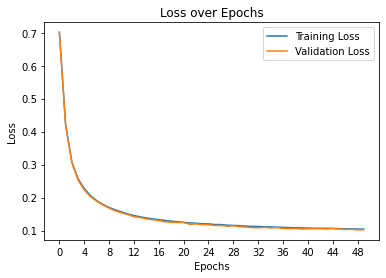

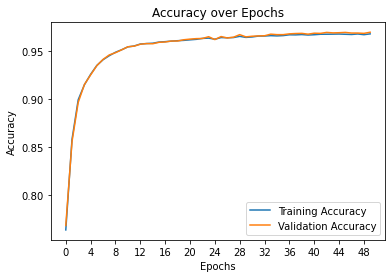

In [705]:
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["validation_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(0, epochs, 4))
plt.show()

plt.plot(history["train_accuracy"], label="Training Accuracy")
plt.plot(history["validation_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(0, epochs, 4))
plt.show()

Neural Network achieved a testing accuracy of 96.64% and a AUC score of 0.9889.


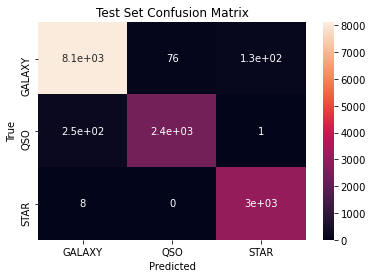

In [706]:
_, test_acc = evaluate(star_classifier, criterion, test_dataloader)

y_hat = star_classifier(torch.Tensor(X_test))
y_pred = y_hat.detach().numpy()
y_pred = y_pred/np.sum(y_pred, axis=1).reshape(y_pred.shape[0], 1)
auc = roc_auc_score(y_test, y_pred, multi_class="ovr")
print(f"Neural Network achieved a testing accuracy of {test_acc*100:.2f}% and a AUC score of {auc:.4f}.")


y_hat = torch.argmax(y_hat, axis=1)
cm = confusion_matrix(y_test, y_hat)
train_fnr = cm[1,0]/(cm[1,0]+cm[1,1])
sns.heatmap(cm, 
            xticklabels=le.classes_, 
            yticklabels=le.classes_, 
            annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()


## Task 3

I started by modifying the batch size beginning at 64 and then increasing by a factor of 2 until the entire training set was used per step. When the entire training set was used it would be a batch gradient descent and with any subpart of the data per step it would be a mini-batch gradient descent. I found that batch size of 256 resulted in the best accuracy and faster convergence.

Next I tried to modify the network width and depth. First I started with a two layer network. I created a network with a hidden layer of width 25, 50 and 100. 100 resulted in the best accuracy and loss. Then I increased the depth of the network and with the new hidden layer tried width 25, 50 and 100. Width of 50 resulted in the best performance. Finally I tried to add another hidden layer but this resulted in lower performance on both the training and testing set. The final network was: input layer of 5 followed by a 100 neuron hidden layer, followed by another 50 neuron hidden layer followed by a 3 neuron output layer.

The next parameter I modified was the learning rate. I tried learning rates 0.001, 0.0001 and 0.00001. Learning rate of 0.001 minimized quickly at first however, once passing a certain loss threshold it stopped minimizing. For 0.00001 the model took a lot of epochs to converge. A learning rate of 0.0001 both converged quickly and achieved very good performance.

I did not regularized since the loss and accuracy of the train and validation sets stayed closed meaning the model was generalizing well and therefore, no regularization was needed.

I used the Adam optimizer since it has been empirically been shown to be a better optimizer then base gradient descent and other optimization algorithms.

## Task 4

### Logistic Regression Baseline

In [707]:
lr_star_classifier = LogisticRegression(C=1)

In [708]:
lr_star_classifier.fit(X_train, y_train)

LogisticRegression(C=1)

SVM achieved a testing accuracy of 95.27% and a AUC score of 0.9846.


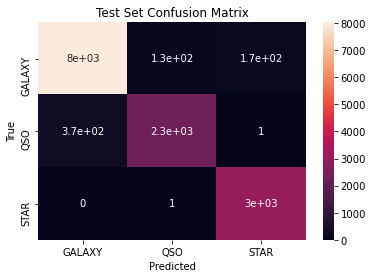

In [709]:
y_hat = lr_star_classifier.predict_proba(X_test)
y_pred = y_hat/np.sum(y_hat, axis=1).reshape(y_hat.shape[0], 1)
auc = roc_auc_score(y_test, y_pred, multi_class="ovr")
test_acc = np.sum(np.argmax(y_hat, axis=1) == y_test)/y_test.shape[0]
print(f"SVM achieved a testing accuracy of {test_acc*100:.2f}% and a AUC score of {auc:.4f}.")

y_hat = np.argmax(y_hat, axis=1)
cm = confusion_matrix(y_test, y_hat)
train_fnr = cm[1,0]/(cm[1,0]+cm[1,1])
sns.heatmap(cm, 
            xticklabels=le.classes_, 
            yticklabels=le.classes_, 
            annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()

### Model Comparison
The neural network performed better than the logistic regression model. The neural network achieved a testing accuracy of 96.64% and an AUC score of 0.9889, while the logistic regression model got a 95.27% testing accuracy and a 0.9846 AUC score. The AUC score tells us how well the model can differentiate between different classes, and a 1 is a perfect score. Both models achieved a good AUC score; however, the neural network scored higher. I believe that the neural network's ability to tap into the nonlinear relationships between the features allowed it to achieve a better score on this test. However, it's clear from the logistic regression score that data is primarily linear, with minimal nonlinear relationships.